# TERM PAPER TEAM DVD TECH-2

## PART 1 - reading in the data


In [2]:
#importing all the libraries needed for the tasks.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### TASK 1

In [3]:
#reading in the data
DATA_PATH = 'data'
data = []
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ['2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']
for year in years:
    for month in months:
        try:
            filename = f'{DATA_PATH}/SCE-{month}-{year}.csv'
            df = pd.read_csv(filename,sep=';')
            data.append(df)
        except FileNotFoundError:
            # Error handelig since data is not present for all months in 2013
            continue

In [4]:
#merging all the dataframes in the data list into a single dataframe
df = pd.concat(data, ignore_index=True)

### TASK 2

In [5]:
# 2.1 number of unique individuals in the dataset
def num_unique_id():
    return len(df['userid'].unique())

print(f'Number of unique individuals in the dataset: {num_unique_id()}')

Number of unique individuals in the dataset: 23369


In [6]:
#2.2 number of rows in the dataset
def num_rows():
    return len(df)

print(f'Number of rows in the dataset: {num_rows()}')

Number of rows in the dataset: 176101


In [7]:
#2.3 number of unique survey waves
def unique_wid():
    return len(df['wid'].unique())

print(f'Number of unique survey waves: {unique_wid()}')

Number of unique survey waves: 139


In [8]:
#2.4 The first and last dates observed in the dataset.
first = df['date'].min()
print(f'First date observed in the dataset: {first}')
last = df['date'].max()
print(f'Last date observed in the dataset: {last}')

First date observed in the dataset: 2013-06-01
Last date observed in the dataset: 2024-12-31


## PART 2 - data pre-processing

### TASK 1

In [9]:
# Fill missing numeracy variables(num_lit_X_correct where X is a number)
num_cols = ['num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct', 'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct']

# Fill missing numeracy values with the first available non-missing value per user
# bfill() is used in case the first value is NaN, ensuring that a non-missing value is used to fill in columns backwards as well
for col in num_cols:
    df[col] = df.groupby('userid')[col].transform(lambda x: x.ffill().bfill())

### TASK 2

In [10]:
#2 drop all observationswith missing values
#1.for demographic variables(gender,age,education_level)
before = len(df)
df = df.dropna(subset=['female','age','educ'])
after_demographics = len(df)
print("Dropped demographics: ", before - after_demographics)

Dropped demographics:  868


In [11]:
#2.2  The three expectations questions about inflation, house price changes, and the stock market
#using the dropna function to drop rows with missing values in the specified columns
before = len(df)
df = df.dropna(subset=['inflation','house_price_change','prob_stocks_up'])
after_expectations = len(df)
print("Dropped expectations: ", before - after_expectations)

Dropped expectations:  1683


In [12]:
#2.3 The seven numeracy questions (after you have forward-filled nonmissing values in step 1!)
df = df.dropna(subset=num_cols)
after_numeracy = len(df)
print("Dropped demographics: ", after_expectations - after_numeracy)

Dropped demographics:  35974


### TASK 3

In [13]:
#3 Drop outliers (implausibly small or large values). For each expectations response:
expect_vars = ["inflation", "house_price_change", "prob_stocks_up"]
#creating a for loop to drop outliers for each variable in expect_vars
for var in expect_vars:
    low, high = df[var].quantile([0.001, 0.999])
    before = len(df)
    df = df[(df[var] >= low) & (df[var] <= high)]
    print(f"{var}: dropped {before - len(df)} outliers")

inflation: dropped 119 outliers
house_price_change: dropped 179 outliers
prob_stocks_up: dropped 0 outliers


### TASK 4

In [14]:
#Create a new column college equal to 1 if an individual has at least a bachelor’s degree, and 0
#otherwise.
df['college']=  (df["educ"] >= 4).astype(int)
df['college']

30936     1
30937     1
30942     1
30943     1
30944     1
         ..
176096    0
176097    1
176098    0
176099    0
176100    1
Name: college, Length: 137278, dtype: int64

### TASK 5

In [15]:
#total number of correct answers across the seven numeracy questions
df["num_correct"] = df[num_cols].sum(axis=1)
dist = df.groupby("num_correct")["userid"].nunique() / df["userid"].nunique()
print("\nDistribution of numeracy scores (% of individuals):")
print((dist * 100).round(1))

median_score = df["num_correct"].median()
df["num_lit_high"] = (df["num_correct"] > median_score).astype(int)


Distribution of numeracy scores (% of individuals):
num_correct
0.0     0.1
1.0     0.7
2.0     2.4
3.0     5.7
4.0    10.5
5.0    16.9
6.0    27.4
7.0    36.2
Name: userid, dtype: float64


### TASK 6

In [16]:
# Report the same sample statistics as in Part 1 for the final data set.
print(f'Number of unique individuals in the dataset: {num_unique_id()}')
print(f'Number of rows in the dataset: {num_rows()}')
print(f'Number of unique survey waves: {unique_wid()}')

Number of unique individuals in the dataset: 17701
Number of rows in the dataset: 137278
Number of unique survey waves: 117


## PART 3

### TASK 1 and 2

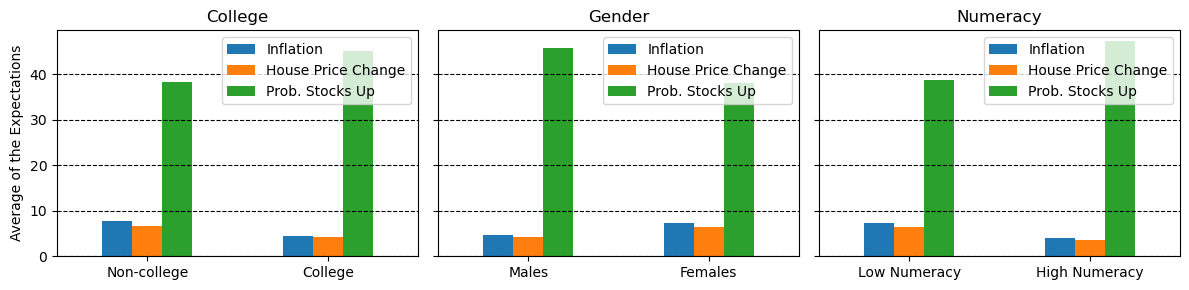

In [17]:
groups = [
    ("college", {0: "Non-college", 1: "College"}, "College"),
    ("female", {0: "Males", 1: "Females"}, "Gender"),
    ("num_lit_high", {0: "Low Numeracy", 1: "High Numeracy"}, "Numeracy")
]

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for ax, (col, mapping, title) in zip(axes, groups):
    group_means = df.groupby(col)[["inflation", "house_price_change", "prob_stocks_up"]].mean().reset_index()
    group_means[col] = group_means[col].map(mapping)

    Plotting_Values = group_means.set_index(col)

    Plotting_Values.plot(kind = 'bar', ax= ax, legend = False)
    ax.set_title(title)
    ax.set_ylabel("Average of the Expectations")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.set_xlabel("")
    ax.grid(True, axis="y", linestyle="--", alpha=1, color = 'black')
    ax.legend(["Inflation", "House Price Change", "Prob. Stocks Up"], loc='upper right')

fig.tight_layout()

